# WallStreetBests: Reddit Sentiment $\implies$ Stock Alpha

In [2]:
import pandas as pd
import numpy as np

import ast # Used to convert the list representation to an actual list

# Adjust path in order to access preprocessing code
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
import src.preprocess as preprocess

## 1: Quick data audit

In [3]:
# Read in Reddit data as pd.DataFrame
reddit = (pd.read_csv('../data/reddit_wsb_with_sentiment.csv')
          .drop(['Unnamed: 0.1', 'Unnamed: 0'],
                axis=1,
                errors='ignore'))
reddit['ticker'] = reddit['ticker'].apply(ast.literal_eval)
reddit.head()

,title,score,id,url,comms_num,created,body,timestamp,raw_text,ticker,sentiment
0,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35,Exit the system The CEO of NASDAQ pushed to ha...,"[CEO, GME]",-0.062377
1,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,"[NEW, FOR, GME, CAN]",-0.008729
2,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56,"Not to distract from GME, just thought our AMC...","[GME, AMC]",0.085851
3,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE,317,l6uf6d,https://www.reddit.com/r/wallstreetbets/commen...,53,1.611862e+09,Hedgefund whales are spreading disinfo saying ...,2021-01-28 21:26:27,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE He...,"[AN, GME, ITM, DON, DON, BE]",-0.150121
4,THIS IS THE MOMENT,405,l6ub9l,https://www.reddit.com/r/wallstreetbets/commen...,178,1.611862e+09,Life isn't fair. My mother always told me that...,2021-01-28 21:19:31,THIS IS THE MOMENT Life isn't fair. My mother ...,"[ARE, GME, BB]",-0.128038


### 1a: Null counts per column

In [4]:
# For each column
null_counts = pd.DataFrame(columns=['column_name', 'null_count'])
for col in reddit.columns:
    # Count returns the number of non null values in an object
    current = pd.DataFrame({'column_name' : [col], 'null_count' : [reddit[col].count()]})
    null_counts = pd.concat([null_counts, current])
null_counts

,column_name,null_count
0,title,28909
0,score,28909
0,id,28909
0,url,28909
0,comms_num,28909
0,created,28909
0,body,18008
0,timestamp,28909
0,raw_text,28909
0,ticker,28909


### 1b: Top-10 tickers by post count and by up-vote score.

In [5]:
# Copies each row for each ticker it contains information about
reddit_exploded = reddit.explode('ticker')
ticker_stats = reddit_exploded.groupby('ticker').agg({
    'score' : ['count', 'sum'] # Score maps to these two functions
}).round(2)

# Flatten column names- otherwise there is a row before called 'score'
ticker_stats.columns = ['post_count', 'cum_score']
ticker_stats = ticker_stats.reset_index() # Otherwise, ticker is the index, we want as column

print('Top 10 Tickers by Post Count')
print(ticker_stats.sort_values('post_count', ascending=False).head(10))

print()

print('Top 10 Tickers by Aggregate Score')
print(ticker_stats.sort_values('cum_score', ascending=False).head(10))

Top 10 Tickers by Post Count
     ticker  post_count  cum_score
926     GME       23682   46155124
86      AMC        7902    6287943
1022   HOLD        3682    2731854
196      BB        3142    1788179
297     BUY        2466    1429137
1508    NOK        2233     822555
1796     RH        2211    1936715
837     FOR        1838    1626893
361     CEO        1747    1635297
734      EV        1516     444604

Top 10 Tickers by Aggregate Score
     ticker  post_count  cum_score
926     GME       23682   46155124
86      AMC        7902    6287943
658    EDIT        1101    3068151
1022   HOLD        3682    2731854
1146     IT        1295    2130008
1796     RH        2211    1936715
1957    SLV         585    1878881
196      BB        3142    1788179
1150    ITM         751    1684780
361     CEO        1747    1635297


## 2: Daily sentiment feature

### 2a: Use VADER (or FinBERT for finance-tuned) to score each post

Text(0.5, 1.0, 'Distribution of Sentiment Scores Across Posts')

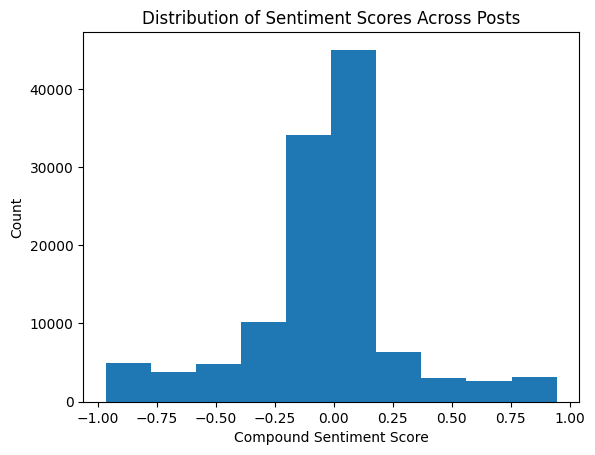

In [6]:
import matplotlib.pyplot as plt

# Distribution of posts
plt.hist(reddit_exploded['sentiment'])
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Scores Across Posts')

### 2b: Aggregate to sent_mean, sent_median, bull_ratio by ticker-date.

In [7]:
def classify_bull_bear(compound_score):
    '''
    Classifies a post as either bullish or bearish by
    predetermined thresholds on the sentiment score.
    Parameters:
    compound_score (float): the compound sentiment score of the post to be classified
    Returns:
    str (bullish, bearish, neutral): the output label
    '''
    if compound_score >= .05:
        return 'bullish'
    elif compound_score <= -.05:
        return 'bearish'
    else:
        return 'neutral'

def bull_ratio(series):
    '''
    Computes the bull ratio for a group of tickers in a pd.DataFrame.
    Parameters:
    group (pd.Series): a series containing 'bull'/'bear' sentiment classificaitons
    Returns:
    float: bull ratio = #bullish/(#bullish + #bearish)
    '''
    bull_count = (series == 'bullish').sum()
    bear_count = (series == 'bearish').sum()
    total = bull_count + bear_count
    return bull_count / total if total > 0 else np.nan # Gracefully handle zero case

In [16]:
# Create a column to only store date
reddit_exploded['date'] = pd.to_datetime(reddit_exploded['timestamp'])
reddit_exploded['date'] = reddit_exploded['date'].dt.date
reddit_exploded['bull_bear'] = reddit_exploded['sentiment'].apply(classify_bull_bear)

date_stats = reddit_exploded.groupby(['date', 'ticker']).agg(
    sent_mean=('sentiment', 'mean'),
    sent_median=('sentiment', 'median'),
    bull_ratio=('bull_bear', bull_ratio),
    post_count=('sentiment', 'count')
)

date_stats = date_stats.reset_index()
date_stats

,date,ticker,sent_mean,sent_median,bull_ratio,post_count
0,2020-09-29,CBAT,0.635384,0.635384,1.0,4
1,2020-09-29,ES,0.635384,0.635384,1.0,1
2,2020-09-29,EV,0.635384,0.635384,1.0,2
3,2020-09-29,OXBR,0.635384,0.635384,1.0,1
4,2020-09-29,SPI,0.635384,0.635384,1.0,1
...,...,...,...,...,...,...
20509,2021-08-16,PT,0.374970,0.374970,1.0,1
20510,2021-08-16,SEE,0.194275,0.194275,1.0,1
20511,2021-08-16,TGT,0.013615,0.013615,NaN,2
20512,2021-08-16,VZ,0.762364,0.762364,1.0,1


Text(0.5, 1.0, 'Distribution of Bull Ratios')

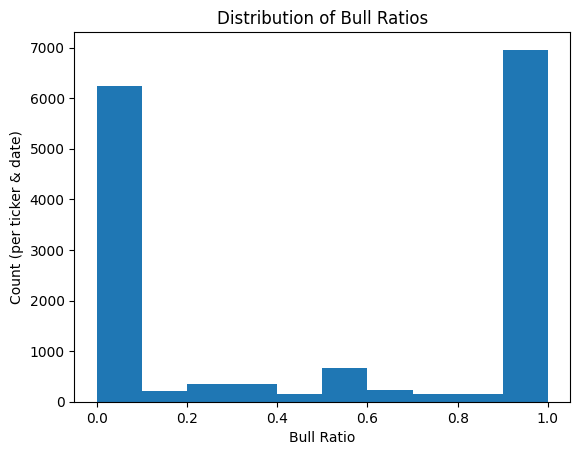

In [10]:
# Plot all bull ratios that are not NA
plt.hist(date_stats['bull_ratio'].dropna())
plt.xlabel('Bull Ratio')
plt.ylabel('Count (per ticker & date)')
plt.title('Distribution of Bull Ratios')

## 3: Merge with daily returns

### 3a: Pull close-to-close log-return from Yahoo! Finance

In [ ]:
'''
import yfinance as yf

# Tickers we need - come from symbols_valid_meta.csv
tickers = reddit_exploded['ticker'].unique().tolist()

print(f"Downloading data for {len(tickers)} tickers...")
print(f"Sample tickers: {tickers[:10]}")  # Debug: show first 10 tickers

# Download in smaller batches to avoid thread limits
batch_size = 10  # Reduce batch size for better debugging
all_price_data = []

for i in range(0, len(tickers), batch_size):
    batch_tickers = tickers[i:i+batch_size]
    print(f"Processing batch {i//batch_size + 1}/{(len(tickers)-1)//batch_size + 1}: {batch_tickers}")
    
    try:
        # Download price history for this batch
        batch_prices = yf.download(
            tickers=" ".join(batch_tickers),
            start="2015-01-01",
            end="2025-01-01",
            group_by="ticker" if len(batch_tickers) > 1 else None,
            auto_adjust=False,  # Change this to False to get 'Adj Close'
            progress=False,
            threads=False  # Disable threading for now
        )
        
        print(f"Batch data shape: {batch_prices.shape}")
        print(f"Batch columns: {batch_prices.columns.tolist()[:5]}...")  # Show first 5 columns
        
        # Process this batch
        for tkr in batch_tickers:
            try:
                if len(batch_tickers) == 1:
                    # Single ticker doesn't get grouped
                    if not batch_prices.empty and 'Adj Close' in batch_prices.columns:
                        sub = batch_prices.reset_index()[["Date", "Adj Close"]]
                    else:
                        print(f"No data for {tkr}")
                        continue
                else:
                    # Multiple tickers are grouped - columns are (ticker, 'Adj Close')
                    try:
                        # Check if ticker exists in the data
                        if hasattr(batch_prices.columns, 'levels') and tkr in batch_prices.columns.levels[0]:
                            # Access the ticker's data directly
                            ticker_data = batch_prices[tkr]
                            if 'Adj Close' in ticker_data.columns:
                                sub = ticker_data.reset_index()[["Date", "Adj Close"]]
                            else:
                                print(f"No Adj Close for {tkr}")
                                continue
                        else:
                            print(f"Warning: {tkr} not found in batch data")
                            continue
                    except Exception as e:
                        print(f"Error accessing data for {tkr}: {e}")
                        continue
                
                # Check if we have valid data
                if sub.empty or sub['Adj Close'].isna().all():
                    print(f"No valid price data for {tkr}")
                    continue
                
                sub["ticker"] = tkr
                sub = sub.rename(columns={"Date": "date", "Adj Close": "close"})
                all_price_data.append(sub)
                print(f"Successfully processed {tkr}: {len(sub)} rows")
                
            except Exception as e:
                print(f"Error processing {tkr}: {e}")
                continue
                    
    except Exception as e:
        print(f"Error downloading batch starting at index {i}: {e}")
        continue
    
    # Add a small delay between batches
    import time
    time.sleep(1)

# Combine all batches
if all_price_data:
    price_df = pd.concat(all_price_data, ignore_index=True)
    
    print(f"Combined data shape: {price_df.shape}")
    print(f"Sample data:\n{price_df.head()}")
    
    # Compute next-day-return
    price_df = price_df.sort_values(["ticker", "date"])
    price_df["next_day_return"] = (
        price_df.groupby("ticker")["close"]
                .pct_change()
                .shift(-1)
    )
    
    price_df.to_csv('yf_ticker.csv', index=False)
    print(f"Successfully downloaded data for {price_df['ticker'].nunique()} unique tickers")
else:
    print("No price data was successfully downloaded")
    
# Debug: Check what tickers we actually got
if 'price_df' in locals():
    successful_tickers = price_df['ticker'].unique()
    failed_tickers = set(tickers) - set(successful_tickers)
    print(f"Successful tickers: {len(successful_tickers)}")
    print(f"Failed tickers: {len(failed_tickers)}")
    if failed_tickers:
        print(f"Some failed tickers: {list(failed_tickers)[:10]}")
'''

In [ ]:
# Merge with ticker data
price_df = pd.read_csv('yf_ticker.csv').drop('Unnamed: 0', axis = 1, errors='ignore')

# Only keep rows that have at least three associated posts
date_stats = date_stats[date_stats['post_count'] >= 3]

# Type conversion of the date property so it merges properly
price_df['date'] = pd.to_datetime(price_df['date'])
date_stats['date'] = pd.to_datetime(date_stats['date'])

merged = pd.merge(date_stats,
                  price_df,
                  on=['ticker', 'date'])
merged

,date,ticker,sent_mean,sent_median,bull_ratio,post_count,close,next_day_return
0,2020-09-29,CBAT,0.635384,0.635384,1.000000,4,2.360000,-0.144068
1,2021-01-28,AA,-0.028770,0.030406,0.000000,3,17.779032,-0.027027
2,2021-01-28,AAL,-0.014923,-0.034014,0.333333,20,18.100000,-0.051381
3,2021-01-28,AG,-0.245466,-0.245466,0.000000,6,16.661783,0.074733
4,2021-01-28,AGI,0.002352,0.002352,NaN,3,7.732529,-0.006211
...,...,...,...,...,...,...,...,...
4041,2021-08-13,USD,0.574726,0.574726,1.000000,5,17.562143,-0.009042
4042,2021-08-13,VFH,0.004291,0.004291,NaN,3,87.223358,-0.002001
4043,2021-08-16,CSCO,0.013615,0.013615,NaN,5,49.950634,-0.004797
4044,2021-08-16,FUD,0.374970,0.374970,1.000000,3,NaN,0.000000


## 4: Train/test split

### 4a: Split 50-50 chronologically

In [38]:
merged = merged.sort_values('date')
N = len(merged)//2
train = merged[:N].dropna()
test = merged[N:].dropna()


### 4b: Explain why a chronological split avoids look-ahead bias
**look-ahead bias** occurs when a study or simulation incorporates information that would not have been available at the time of being analysed.

We would not want to use posts that *had not yet occured* and may contain information about the market that was unavailable at the time of stock purchase.

## 5: Baseline linear model
OLS of next_day_return on sent_mean. Report in/out-sample $R^2$.

In [39]:
from sklearn.linear_model import LinearRegression
# Separate predictors and target
X_train = train[['sent_mean']]
y_train = train[['next_day_return']]

X_test = test[['sent_mean']]
y_test = test[['next_day_return']]

# Fit model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [45]:
from sklearn.metrics import r2_score, mean_absolute_error

# Obtain predictions for in and out-of-sample
y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

# Obtain R^2
r_squared_in_sample = r2_score(y_train, y_train_pred)
r_squared_out_of_sample = r2_score(y_test, y_test_pred)
print(f'in sample R^2: {r_squared_in_sample}')
print(f'out-of-sample R^2: {r_squared_out_of_sample}')

# Obtain MAE
mae_in_sample = mean_absolute_error(y_train, y_train_pred)
mae_out_of_sample = mean_absolute_error(y_test, y_test_pred)
print(f'in sample MAE: {mae_in_sample}')
print(f'out of sample MAE: {mae_out_of_sample}')

in sample R^2: 2.0736919499775297e-05
out-of-sample R^2: -0.02236596102534727
in sample MAE: 0.035958152896513766
out of sample MAE: 0.028827548192815456


$$R^2 = 1 - \frac{SS_{RES}}{SS_{TOT}}$$

Text(0.5, 1.0, 'Relationship between Mean Sentiment and Next Day Returns')

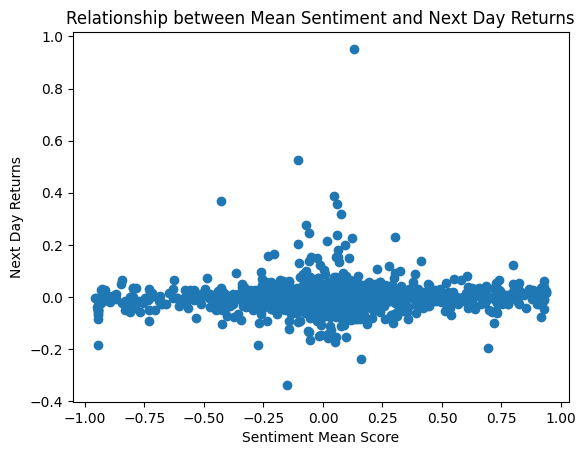

In [43]:
plt.plot(test['sent_mean'], test['next_day_return'], 'o')
plt.xlabel('Sentiment Mean Score')
plt.ylabel('Next Day Returns')
plt.title('Relationship between Mean Sentiment and Next Day Returns')

In [46]:
from xgboost import XGBRegressor
X_train = train[['sent_mean', 'sent_median', 'bull_ratio']]
y_train = train[['next_day_return']]
X_test = test[['sent_mean', 'sent_median', 'bull_ratio']]
y_test = test[['next_day_return']]

xgb_model = XGBRegressor(objective='reg:squarederror', eval_metric='mae')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

xgb_mae_test = mean_absolute_error(y_test, y_pred)
print(f'mean absolute error on test set: {xgb_mae_test}')

mean absolute error on test set: 0.03998436778783798


/var/folders/bz/c0m7m3795n93s2l2k3d7hf8h0000gn/T/ipykernel_36106/2715727394.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(features, rotation=90)


Text(0.5, 1.0, 'Feature Importance')

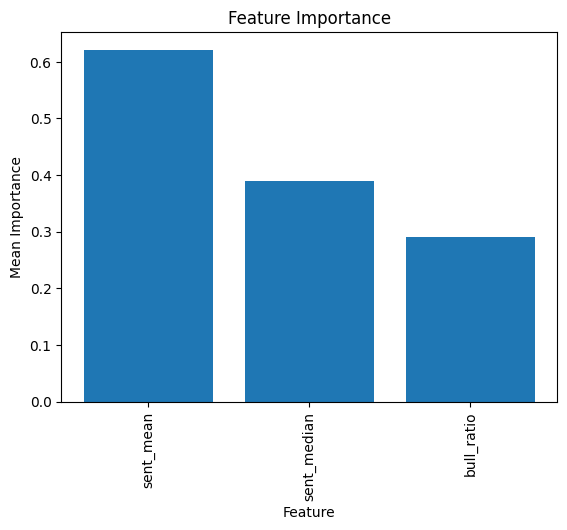

In [49]:
from sklearn.inspection import permutation_importance

fig, ax = plt.subplots()

result = permutation_importance(xgb_model, X_test, y_test, n_repeats = 10)
importances_mean = result.importances_mean
features = X_test.columns

plt.bar(features, importances_mean)
ax.set_xticklabels(features, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Mean Importance')
plt.title('Feature Importance')

## 7: Weekly Information-Coefficient

### 7a: For each week in the test set, compute Spearman rank IC across tickers.

In [ ]:
from scipy.stats import spearmanr

test_results = X_test.copy()
test_results['actual_returns'] = y_test
test_results['predicted_returns'] = y_pred

corrs = []